In [2]:
from web3 import Web3

In [3]:
alchemy_url = 'https://eth-mainnet.g.alchemy.com/v2/1rwsoWQI88ghrZaNBB'
w3 = Web3(Web3.HTTPProvider(alchemy_url))
print("Connected:", w3.is_connected())

Connected: True


In [4]:
# wallet and USDC addresses
wallet_address = w3.to_checksum_address("0x742d35Cc6634C0532925a3b844Bc454e4438f44e")
usdc_contract = w3.to_checksum_address("0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606EB48")




In [5]:
# Mini USDC ABI to read Transfer events
usdc_abi = [
    {
        "anonymous": False,
        "inputs": [
            {"indexed": True, "internalType": "address", "name": "from", "type": "address"},
            {"indexed": True, "internalType": "address", "name": "to", "type": "address"},
            {"indexed": False, "internalType": "uint256", "name": "value", "type": "uint256"}
        ],
        "name": "Transfer",
        "type": "event"
    }
]

In [6]:
# contract instance
usdc = w3.eth.contract(address=usdc_contract, abi=usdc_abi)

In [7]:
# Latest block
latest_block = w3.eth.block_number
print(f"Latest block: {latest_block}")

Latest block: 22373111


In [8]:
from_block = latest_block - 1000
to_block = latest_block

In [9]:
# Transfer event signature hash
transfer_topic = w3.keccak(text="Transfer(address,address,uint256)").hex()

In [10]:
try:
    # Transfer logs from USDC
    logs = w3.eth.get_logs({
        "fromBlock": w3.to_hex(from_block),
        "toBlock": w3.to_hex(to_block),
        "address": usdc_contract,
        "topics": ["0x" + transfer_topic if not transfer_topic.startswith("0x") else transfer_event_sig]
    })
     
    print(f"✅ Found {len(logs)} USDC Transfer events in last 2000 blocks.")
    

    for i, log in enumerate(logs[:10]):
        try:
            # Convert topic bytes to hex string then extract address
            from_addr = "0x" + log["topics"][1].hex()[-40:]
            to_addr = "0x" + log["topics"][2].hex()[-40:]
            
         
            value = int(log["data"].hex(), 16) / 10**6  # USDC has 6 decimals
            print(f"🟢 {from_addr} → {to_addr}: {value} USDC")
        except Exception as e:
            print(f"⚠️ Could not decode log {i}: {e}")
        
except Exception as e:
    print(f"❌ Error: {e}")



✅ Found 29888 USDC Transfer events in last 2000 blocks.
🟢 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 → 0x66a9893cc07d91d95644aedd05d03f95e1dba8af: 15.287766 USDC
🟢 0x66a9893cc07d91d95644aedd05d03f95e1dba8af → 0x3416cf6c708da44db2624d63ea0aaef7113527c6: 15.287766 USDC
🟢 0xc026395860db2d07ee33e05fe50ed7bd583189c7 → 0x60a5b234647bbc643e8fd196f7b813de773b321c: 45393.793866 USDC
🟢 0x9a84a1852bc7fb608794960960adb04666a12b41 → 0x5141b82f5ffda4c6fe1e372978f1c5427640a190: 140.31042 USDC
🟢 0x5141b82f5ffda4c6fe1e372978f1c5427640a190 → 0xe0554a476a092703abdb3ef35c80e0d76d32939f: 140.31042 USDC
🟢 0x2704a8dcc3a02622f7801bb7f51455ef928c9e96 → 0xdd3d72c53ff982ff59853da71158bf1538b3ceee: 125.510024 USDC
🟢 0xb8c2282aedcd9cee03dbe0bd8dad95d2a17e2252 → 0x6de00173e01bf336f2aa8596ddc6312cbb77d21f: 0.0 USDC
🟢 0x1e071abbac01351bb54b5b99a51469743b8d784f → 0x48ef641a603d3bd06096b6b47e9e6eb81df22245: 0.0 USDC
🟢 0xbead1ef6dea797d9afc0127a93e667184c7460be → 0x36600a89dd7d6646bbd1d99eda2ade8097ecd379: 0.0 USDC
🟢 0x

In [11]:
big_transfers = []

try:
    logs = w3.eth.get_logs({
        "fromBlock": w3.to_hex(from_block),
        "toBlock": w3.to_hex(to_block),
        "address": usdc_contract,
        "topics": [transfer_topic if transfer_topic.startswith("0x") else "0x" + transfer_topic]
    })
    
    print(f"✅ Found {len(logs)} USDC Transfer events in last 5000 blocks.")

    for i, log in enumerate(logs):
        try:
            from_addr = "0x" + log["topics"][1].hex()[-40:]
            to_addr = "0x" + log["topics"][2].hex()[-40:]
            value = int(log["data"].hex(), 16) / 10**6  # convert to human-readable USDC
            
            if value >= 10000:  # filter big transfers
                big_transfers.append({
                    "from": from_addr,
                    "to": to_addr,
                    "value": value
                })
        except Exception as e:
            print(f"⚠️ Could not decode log {i}: {e}")
        
except Exception as e:
    print(f"❌ Error: {e}")


print(f"🔎 Found {len(big_transfers)} big transfers over $10,000 USDC!")
for tx in big_transfers[:10]:  # Show only first 10 big transfers
    print(f"🟢 {tx['from']} → {tx['to']}: {tx['value']} USDC")


✅ Found 29888 USDC Transfer events in last 5000 blocks.
🔎 Found 3362 big transfers over $10,000 USDC!
🟢 0xc026395860db2d07ee33e05fe50ed7bd583189c7 → 0x60a5b234647bbc643e8fd196f7b813de773b321c: 45393.793866 USDC
🟢 0x5050e08626c499411b5d0e0b5af0e83d3fd82edf → 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640: 50121.424771 USDC
🟢 0x093e8b9985c5c7e79e8790293b3fc6428612f9be → 0xd4e9b0d466789d7f6201442eeccba6a75a552db0: 28551.697856 USDC
🟢 0xd4e9b0d466789d7f6201442eeccba6a75a552db0 → 0x00c600b30fb0400701010f4b080409018b9006e0: 28551.697856 USDC
🟢 0x00c600b30fb0400701010f4b080409018b9006e0 → 0x31373595f40ea48a7aab6cbcb0d377c6066e2dca: 28551.697856 USDC
🟢 0x51c72848c68a965f66fa7a88855f9f7784502a7f → 0x52aa899454998be5b000ad077a46bbe360f4e497: 20081.054687 USDC
🟢 0x51c72848c68a965f66fa7a88855f9f7784502a7f → 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640: 34858.398437 USDC
🟢 0x51c72848c68a965f66fa7a88855f9f7784502a7f → 0x52aa899454998be5b000ad077a46bbe360f4e497: 28345.703125 USDC
🟢 0x51c72848c68a965f66fa7a

In [12]:
from collections import defaultdict

wallet_totals = defaultdict(float)

# Sum USDC moved for each wallet
for tx in big_transfers:
    wallet_totals[tx["from"]] += tx["value"]
    wallet_totals[tx["to"]] += tx["value"]

# Sort wallets by total USDC moved (descending order)
top_wallets = sorted(wallet_totals.items(), key=lambda x: x[1], reverse=True)

# Show top 10 wallets
print("\n🏆 Top 10 Wallets by USDC Moved:")
for i, (wallet, total) in enumerate(top_wallets[:10], 1):
    print(f"{i}. {wallet} moved {total:,.2f} USDC")



🏆 Top 10 Wallets by USDC Moved:
1. 0xa69babef1ca67a37ffaf7a485dfff3382056e78c moved 902,199,093.66 USDC
2. 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 moved 717,013,329.32 USDC
3. 0x28c6c06298d514db089934071355e5743bf21d60 moved 176,304,534.63 USDC
4. 0x21a31ee1afc51d94c2efccaa2092ad1028285549 moved 155,399,855.71 USDC
5. 0x55fe002aeff02f77364de339a1292923a15844b8 moved 139,565,022.13 USDC
6. 0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8 moved 112,600,593.65 USDC
7. 0xa9d1e08c7793af67e9d92fe308d5697fb81d3e43 moved 88,362,377.20 USDC
8. 0x9a772018fbd77fcd2d25657e5c547baff3fd7d16 moved 80,044,960.74 USDC
9. 0x0000000000000000000000000000000000000000 moved 70,595,131.51 USDC
10. 0xbbbbbbbbbb9cc5e90e3b3af64bdaf62c37eeffcb moved 46,853,006.62 USDC


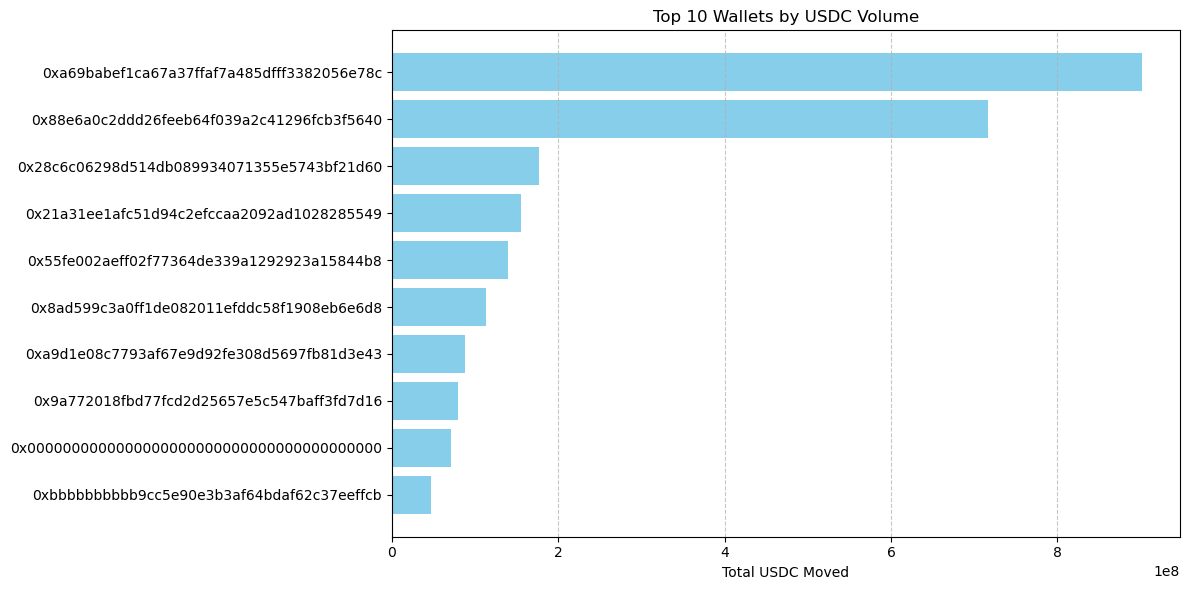

In [13]:
import matplotlib.pyplot as plt

# Take top 10 wallets
top_wallets = sorted(wallet_totals.items(), key=lambda x: x[1], reverse=True)[:10]

# Split into two lists for plotting
wallets = [w[0] for w in top_wallets]
amounts = [w[1] for w in top_wallets]

# Plot
plt.figure(figsize=(12, 6))
plt.barh(wallets, amounts, color='skyblue')
plt.xlabel('Total USDC Moved')
plt.title('Top 10 Wallets by USDC Volume')
plt.gca().invert_yaxis()  # Highest at top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the chart
plt.show()


In [14]:

sent_amounts = {}
received_amounts = {}

#  Loop through all USDC Transfer Logs
for log in logs:
    from_addr = "0x" + log["topics"][1].hex()[-40:]
    to_addr = "0x" + log["topics"][2].hex()[-40:]
    value = int(log["data"].hex(), 16) / 10**6 

    # Update sent amounts
    sent_amounts[from_addr] = sent_amounts.get(from_addr, 0) + value

    # Update received amounts
    received_amounts[to_addr] = received_amounts.get(to_addr, 0) + value

for wallet in list(sent_amounts.keys())[:5]:
    sent = sent_amounts.get(wallet, 0)
    received = received_amounts.get(wallet, 0)
    net = received - sent
    print(f" Wallet {wallet} - Sent: {sent:.2f} USDC, Received: {received:.2f} USDC, Net: {net:.2f} USDC")

 Wallet 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 - Sent: 358168878.19 USDC, Received: 359569473.43 USDC, Net: 1400595.24 USDC
 Wallet 0x66a9893cc07d91d95644aedd05d03f95e1dba8af - Sent: 747720.13 USDC, Received: 747720.13 USDC, Net: -0.00 USDC
 Wallet 0xc026395860db2d07ee33e05fe50ed7bd583189c7 - Sent: 1590068.28 USDC, Received: 1917017.59 USDC, Net: 326949.31 USDC
 Wallet 0x9a84a1852bc7fb608794960960adb04666a12b41 - Sent: 303.19 USDC, Received: 55.49 USDC, Net: -247.69 USDC
 Wallet 0x5141b82f5ffda4c6fe1e372978f1c5427640a190 - Sent: 5103730.15 USDC, Received: 5103730.15 USDC, Net: 0.00 USDC
